In [1]:
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sparse
from scipy.stats import pearsonr

from scipy.cluster.hierarchy import linkage
import scipy.spatial.distance as ssd

import seaborn as sns
import sys
from scipy.sparse import hstack, csr_matrix
from sklearn.feature_selection import mutual_info_classif
import os
# from cnmf import cNMF, save_df_to_npz, load_df_from_npz
import harmonypy
from adjustText import adjust_text

from matplotlib.patches import Patch
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.patches import Rectangle
from matplotlib.pyplot import rc_context

### UMAP Visualization

Dataset with percent.mt >= 10

#### Importing from H5ad (issues)

In [2]:
postTrans_rev = sc.read_h5ad("./Data/h5ad/postTransCD34.h5ad")

KeyError: "Unable to synchronously open object (object 'obs' doesn't exist)"

In [ ]:
print(postTrans_rev.obs.columns)

#### Importing from Seurat Coords

In [10]:
umap_coords = pd.read_csv("postTrans_coordinates.csv", index_col = 0)

In [11]:
print(umap_coords.head())

                            umap_1    umap_2  cluster
A_AAACGCTTCACTTGTT_A_pos -3.854382 -8.391539        4
A_AAAGGATCAATGCAGG_A_pos  4.369910  0.575330        9
A_AAAGGATGTGCGAGTA_A_pos -2.621185 -7.562319        4
A_AAAGGATTCACTGATG_A_pos  3.144841  0.364132        2
A_AAAGGGCCACCCTCTA_A_pos -6.825977 -1.130658        7


#### Plotting UMAP 

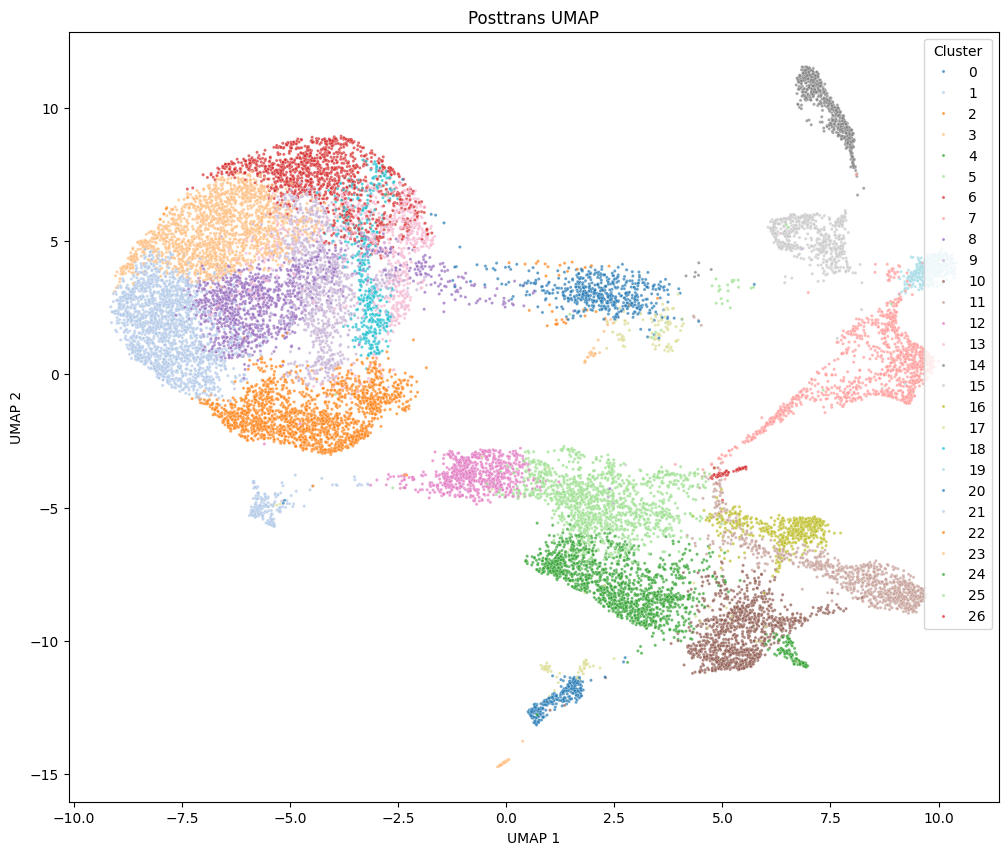

In [17]:
plt.figure(figsize=(12, 10))

sns.scatterplot(
    x=-umap_coords.iloc[:, 0], 
    y=umap_coords.iloc[:, 1], 
    hue=umap_coords["cluster"], 
    palette="tab20", 
    s=5, alpha=0.7
)

plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.title("Posttrans UMAP")
plt.legend(title = "Cluster")
plt.show()